In [1]:
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import torch
import torch.optim as optim

from data_processing.cifar_100 import Cifar100
from data_processing.data_generator import DataGenerator
from data_processing.transforms import *
from approach_1.models import BaselineResNet
from approach_1.baseline_training import BaselineSolver

%load_ext autoreload
%autoreload 2

In [2]:
hparams = {
    'batch_size': 1,
    'learning_rate': 1e-3,
    'epochs': 2,
    'loss_func': torch.nn.CrossEntropyLoss(),
    'optimizer': optim.AdamW
}

num_classes = 20
freeze=False
patience = 3
repo_root = os.path.abspath(os.getcwd())
data_root = os.path.join(repo_root, "data")
seed = 69
split = 0.7
patch_size = 16

transforms = [RescaleTransform(), ReshapeToTensor(), Patches(patch_size=patch_size), Resize()]
train = Cifar100(root=data_root, purpose='train', seed=seed, split=0.001, transform=transforms)
val = Cifar100(root=data_root, purpose='val', seed=seed, split=0.999, transform=transforms)

train_dataloader = DataGenerator(train, batch_size=hparams['batch_size'])
val_dataloader = DataGenerator(val, batch_size=hparams['batch_size'])
model = BaselineResNet(num_classes=num_classes, hparams=hparams, freeze=freeze)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

solver = BaselineSolver(
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    device=device,
    patience=patience
)

solver.train()

os.makedirs('trained_models', exist_ok=True)
models_path = os.path.join(repo_root, 'trained_models')
model.save(os.path.join(models_path, f'baselinemodel_batch{hparams["batch_size"]}_lr{hparams["learning_rate"]}_epochs{hparams["epochs"]}_freeze{freeze}.model'))

'''
plt.title('Loss curves')
plt.plot(solver.train_loss_history, '-', label='train')
plt.plot(solver.val_loss_history, '-', label='val')
plt.legend(loc='lower right')
plt.xlabel('Iteration')
plt.show()

print("Training accuray: %.5f" % (solver.get_dataset_accuracy(dataloaders['train_overfit_single_image'])))
print("Validation accuray: %.5f" % (solver.get_dataset_accuracy(dataloaders['val_500files'])))
'''

e:\!LMU\PythonProjects\generaldsvenv\lib\site-packages\torch\cuda\__init__.py:52: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 8000). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


[Epoch 1, Iteration     5] loss: 2.68692
[Epoch 1, Iteration    10] loss: 4.53789
[Epoch 1, Iteration    15] loss: 4.01386
[Epoch 1, Iteration    20] loss: 4.49769
[Epoch 1, Iteration    25] loss: 3.55421
[Epoch 1, Iteration    30] loss: 3.56553
[Epoch 1, Iteration    35] loss: 4.65448
[Epoch 1, Iteration    40] loss: 3.48424
[Epoch 1, Iteration    45] loss: 3.35957
[Epoch 1, Iteration    50] loss: 4.12943
Training accuracy after epoch 1: 0.12999999523162842
Validation accuracy after epoch 1: 0.03999999910593033
[Epoch 2, Iteration     5] loss: 4.38255
[Epoch 2, Iteration    10] loss: 2.71874
[Epoch 2, Iteration    15] loss: 2.72712
[Epoch 2, Iteration    20] loss: 3.32118
[Epoch 2, Iteration    25] loss: 3.02486
[Epoch 2, Iteration    30] loss: 3.55531
[Epoch 2, Iteration    35] loss: 3.57472
[Epoch 2, Iteration    40] loss: 2.62976
[Epoch 2, Iteration    45] loss: 2.70567
[Epoch 2, Iteration    50] loss: 3.92151
Training accuracy after epoch 2: 0.10000000149011612
Validation accuracy

'\nplt.title(\'Loss curves\')\nplt.plot(solver.train_loss_history, \'-\', label=\'train\')\nplt.plot(solver.val_loss_history, \'-\', label=\'val\')\nplt.legend(loc=\'lower right\')\nplt.xlabel(\'Iteration\')\nplt.show()\n\nprint("Training accuray: %.5f" % (solver.get_dataset_accuracy(dataloaders[\'train_overfit_single_image\'])))\nprint("Validation accuray: %.5f" % (solver.get_dataset_accuracy(dataloaders[\'val_500files\'])))\n'

In [3]:
hparams = {
    'batch_size': 8,
    'learning_rate': 1e-2,
    'epochs': 1
}

model = ResNet(hparams=hparams)

repo_root = os.path.abspath(os.getcwd())
data_root = os.path.join(repo_root, "data")
seed = 69
split = 0.7

#CNN_model = torch.load(path)
#CNN_model = nn.Sequential(*(list(CNN_model.children())[:-2]))
#for param in CNN_model.parameters():
#    param.requires_grad = False
transforms = [RescaleTransform(), ReshapeToTensor(), Patches(patch_size=16), Resize()]#, PassThroughCNN(CNN_model)]

train = Cifar100(root=data_root, purpose='train', seed=seed, split=split, transform=transforms)
val = Cifar100(root=data_root, purpose='val', seed=seed, split=split, transform=transforms)
test = Cifar100(root=data_root, purpose='test', seed=seed, split=split, transform=transforms)

train_loader = DataGenerator(train, batch_size=model.hparams['batch_size'])
val_loader = DataGenerator(val, batch_size=model.hparams['batch_size'])

criterion = torch.nn.CrossEntropyLoss()
#remember to one hot encode labels!

optimizer = optim.AdamW(list(model.feature_extractor.parameters())+list(model.AdAvgP.parameters())+list(model.FC.parameters()), lr=model.hparams["learning_rate"])

train_loss_history = [] # loss
train_acc_history = [] # accuracy


for epoch in range(hparams['epochs']):
     
    running_loss = 0.0
 
    # Iterating through the minibatches of the data
    for i, batch in enumerate(train_loader):
        
        image, labels = batch['image'], batch['label']

        labels = torch.tensor(labels, dtype=torch.long)

        #labels_onehot = np.zeros((labels.size, model.num_classes))
        #labels_onehot[np.arange(labels.size), labels] = 1
        #labels_onehot = torch.tensor(labels_onehot)

        #image = image.to(device)
        #labels = labels.to(device)
 
        optimizer.zero_grad()              # Reset the parameter gradients  for the current  minibatch iteration
        predictions = model.forward(torch.tensor(image, dtype=torch.float32))         # Perform a forward pass on the network with inputs

        loss = criterion(predictions, labels) # calculate the loss with the network predictions and ground Truth
        loss.backward()             # Perform a backward pass to calculate the gradients
        optimizer.step()            # Optimize the network parameters with calculated gradients

        
        # Accumulate the loss and calculate the accuracy of predictions
        running_loss += loss.item()

        # Print statistics to console
        if i % 1 == 0: # print every 10 mini-batches
            running_loss /= 1
            print("[Epoch %d, Iteration %5d] loss: %.5f" % (epoch+1, i+1, running_loss))
            train_loss_history.append(running_loss)
            running_loss = 0.0

print('FINISH.')

[Epoch 1, Iteration     1] loss: 3.15119
[Epoch 1, Iteration     2] loss: 6.55386
[Epoch 1, Iteration     3] loss: 12.97375
[Epoch 1, Iteration     4] loss: 8.27364
[Epoch 1, Iteration     5] loss: 6.34709
[Epoch 1, Iteration     6] loss: 5.60924
[Epoch 1, Iteration     7] loss: 4.54106
[Epoch 1, Iteration     8] loss: 5.27723
[Epoch 1, Iteration     9] loss: 4.70683
[Epoch 1, Iteration    10] loss: 5.79413
[Epoch 1, Iteration    11] loss: 4.46769
[Epoch 1, Iteration    12] loss: 4.34472
[Epoch 1, Iteration    13] loss: 3.81410
[Epoch 1, Iteration    14] loss: 4.27671
[Epoch 1, Iteration    15] loss: 5.78943
[Epoch 1, Iteration    16] loss: 2.75463
[Epoch 1, Iteration    17] loss: 3.70401
[Epoch 1, Iteration    18] loss: 5.29587
[Epoch 1, Iteration    19] loss: 6.46343
[Epoch 1, Iteration    20] loss: 4.26429
[Epoch 1, Iteration    21] loss: 4.07189
[Epoch 1, Iteration    22] loss: 4.76640
[Epoch 1, Iteration    23] loss: 3.59940
[Epoch 1, Iteration    24] loss: 4.41170
[Epoch 1, Itera

KeyboardInterrupt: 

In [8]:
os.makedirs('trained_models', exist_ok=True)
model.save(os.path.join(repo_root, "trained_models\dummy_resnet.model"))

Saving model... e:\!LMU\PythonProjects\cv_attention\trained_models\dummy_resnet.model


In [26]:
train[1]

{'image': array([[[[0.03529412, 0.04313725, 0.05098039, ..., 0.04705882,
           0.04705882, 0.04705882],
          [0.03529412, 0.04313725, 0.04705882, ..., 0.04313725,
           0.05098039, 0.05882353],
          [0.03137255, 0.03921569, 0.04705882, ..., 0.0627451 ,
           0.06666667, 0.06666667],
          ...,
          [0.43529412, 0.56078431, 0.63137255, ..., 0.42352941,
           0.61960784, 0.69411765],
          [0.49019608, 0.54509804, 0.54901961, ..., 0.46666667,
           0.54509804, 0.50588235],
          [0.47843137, 0.44705882, 0.54509804, ..., 0.49019608,
           0.5372549 , 0.42745098]],
 
         [[0.1254902 , 0.13333333, 0.14117647, ..., 0.16862745,
           0.16862745, 0.16862745],
          [0.1372549 , 0.14509804, 0.14901961, ..., 0.18039216,
           0.17647059, 0.17647059],
          [0.14901961, 0.15686275, 0.16470588, ..., 0.19607843,
           0.19215686, 0.18823529],
          ...,
          [0.41960784, 0.56078431, 0.6       , ..., 0.4156

In [6]:
example_batch = next(iter(train_loader))
example_batch
#example_img = example_batch['image'][0][1]
#plt.imshow(example_img)

{'image': array([[[[0.01486332, 0.01479185, 0.01477216, ..., 0.28798445,
           0.28789722, 0.28758074],
          [0.01485992, 0.01478815, 0.01476838, ..., 0.28608984,
           0.28600237, 0.285685  ],
          [0.01485898, 0.01478713, 0.01476734, ..., 0.28556789,
           0.28548035, 0.28516273],
          ...,
          [0.02697161, 0.02689218, 0.02687029, ..., 0.77027991,
           0.77036542, 0.77067567],
          [0.02695661, 0.02687668, 0.02685466, ..., 0.76925862,
           0.76934532, 0.76965989],
          [0.02690217, 0.02682047, 0.02679797, ..., 0.76555319,
           0.76564421, 0.76597443]],
 
         [[0.00392157, 0.00388753, 0.00387816, ..., 0.18784248,
           0.18778339, 0.187569  ],
          [0.0039556 , 0.00392157, 0.00391219, ..., 0.18758154,
           0.1875222 , 0.18730693],
          [0.00396498, 0.00393095, 0.00392157, ..., 0.18750965,
           0.18745025, 0.18723473],
          ...,
          [0.01564277, 0.01563899, 0.01563795, ..., 0.7102

In [74]:
example_batch['label'].shape

(32,)

In [6]:
def img_to_patch(x, patch_size, flatten_channels=True):
    """
    Inputs:
        x - torch.Tensor representing the image of shape [B, C, H, W]
        patch_size - Number of pixels per dimension of the patches (integer)
        flatten_channels - If True, the patches will be returned in a flattened format
                           as a feature vector instead of a image grid.
    """

    x = x[None, :]
    x = torch.tensor(x)
    B, H, W, C = x.shape
    x = x.reshape(B, H//patch_size, patch_size, W//patch_size, patch_size, C)
    x = x.permute(0, 1, 3, 5, 2, 4) # [B, H', W', C, p_H, p_W]
    x = x.flatten(1,2)              # [B, H'*W', C, p_H, p_W]
    '''
    B, C, H, W = x.shape
    x = x.reshape(B, C, H//patch_size, patch_size, W//patch_size, patch_size)
    x = x.permute(0, 2, 4, 1, 3, 5) # [B, H', W', C, p_H, p_W]
    x = x.flatten(1,2)              # [B, H'*W', C, p_H, p_W]
    '''
    if flatten_channels:
        x = x.flatten(2,4)          # [B, H'*W', C*p_H*p_W]
    return x

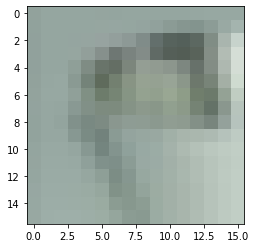

In [11]:
patches = img_to_patch(example_img, 16, flatten_channels=False)
patches.shape
plt.imshow(patches.squeeze()[0].permute(1,2,0))

In [18]:
patches.squeeze()[0].shape
patches2 = patches.squeeze()[0].permute(1,2,0).numpy()

In [19]:
patches2.shape

(16, 16, 3)

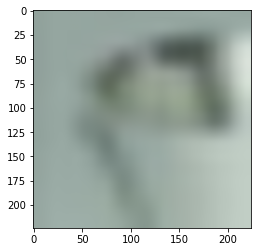

In [20]:
import cv2
newsize = (224, 224)
newimage = cv2.resize(patches2, dsize=newsize, interpolation=cv2.INTER_CUBIC)
plt.imshow(newimage)

In [65]:
del(train)
del(test)
del(val)

NameError: name 'train' is not defined

In [23]:
    def unpickle(file):
        with open(file, 'rb') as fo:
            dict = pickle.load(fo, encoding='bytes')
        return dict

In [24]:
x = unpickle(f'{data_root}\\cifar-100-python\\train')

In [28]:
x.keys()

dict_keys([b'filenames', b'batch_label', b'fine_labels', b'coarse_labels', b'data'])

In [24]:
224*224*3

150528

In [3]:
from data_processing.glaucoma import GONRefuge
import os
from data_processing.transforms import *
import matplotlib.pyplot as plt
from data_processing.data_generator_approach_2 import DataGeneratorA2

%load_ext autoreload
%autoreload 2

repo_root = os.path.abspath(os.getcwd())
data_root = os.path.join(repo_root, "data")
#train = GONRefuge(root=data_root, purpose='train')#, transform=transforms)
patch_num = 8
transforms = [RescaleTransform(), Patches_new(patch_num=patch_num), Resize()]
batch_size = 4

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
test = GONRefuge(root=data_root, purpose='test', transform=transforms)

In [36]:
test_dataloader = DataGeneratorA2(test, batch_size=batch_size, flatten_batch=True)

In [37]:
batchtest = next(iter(test_dataloader))

In [39]:
batchtest['label'].shape

torch.Size([4, 64])

In [6]:
scaled_up = val[0]['image'][34].transpose(1,2,0)
scaled_down = val[1]['image'][25].transpose(1,2,0)

In [2]:
test[0]

{'image': array([[[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
            0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
          [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
            0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
          [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
            0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
          ...,
          [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
            0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
          [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
            0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
          [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
            0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],
 
         [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
            0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
          [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, .

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


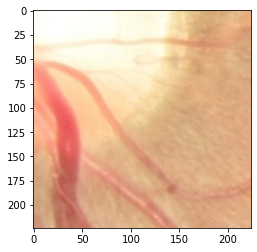

In [7]:
plt.imshow(scaled_up)

In [63]:
imgc['image'].shape

(64, 3, 224, 224)

In [37]:
250//8*8

248

In [23]:
val = GONRefuge(root=data_root, purpose='val')#, transform=transforms)

In [28]:
val[0]['image'].shape

(2056, 2124, 3)

In [1]:
    import os

    ## PyTorch
    import torch
    import torch.optim as optim

    from data_processing.glaucoma import GONRefuge
    from data_processing.data_generator_approach_2 import DataGeneratorA2
    from data_processing.transforms import *
    from approach_2.model import VisionTransformerEmbedded
    #from approach_1.attention_training import AttentionSolver


    hparams = {
        'batch_size': 8,
        'learning_rate': 1e-3,
        'epochs': 2,
        'loss_func': torch.nn.BCEWithLogitsLoss(),
        'optimizer': optim.AdamW
    }

    repo_root = os.path.abspath(os.getcwd())
    data_root = os.path.join(repo_root, "data")

    patch_size = 16 #this is not used either way
    num_patches = 2 #8
    num_classes = 2

    transforms = [RescaleTransform(), Patches_new(patch_num=num_patches), Resize()]
    train = GONRefuge(root=data_root, purpose='train', transform=transforms)
    val = GONRefuge(root=data_root, purpose='val', transform=transforms)

    train_dataloader = DataGeneratorA2(train, batch_size=hparams["batch_size"], flatten_batch=True)
    val_dataloader = DataGeneratorA2(val, batch_size=hparams["batch_size"], flatten_batch=True)

    model = VisionTransformerEmbedded(**{
                                    'embed_dim': 256,
                                    'hidden_dim': 512,
                                    'num_heads': 4,
                                    'num_layers': 2,
                                    'patch_size': patch_size,
                                    'num_patches': num_patches**2,
                                    'num_classes': num_classes,
                                    'dropout': 0.2,
                                    'hparams': hparams
                                })


In [9]:
m = torch.nn.Sigmoid()
loss = torch.nn.BCELoss()
input = torch.randn(3, requires_grad=True)
target = torch.empty(3).random_(2)

In [19]:
target = torch.ones([10, 64], dtype=torch.float32)  # 64 classes, batch size = 10
output = torch.full([10, 64], 1.5)  # A prediction (logit)
pos_weight = torch.ones([64])  # All weights are equal to 1
criterion = torch.nn.BCEWithLogitsLoss()
criterion(output, target)

tensor(0.2014)

In [43]:
loss = torch.nn.BCEWithLogitsLoss()
input = torch.randn(3, requires_grad=True)
target = torch.empty(3).random_(2)
output = loss(input, target)

In [18]:
output

tensor([[1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000,
         1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000,
         1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000,
         1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000,
         1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000,
         1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000,
         1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000,
         1.5000],
        [1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000,
         1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000,
         1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000,
         1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000,
         1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000,
         1

In [12]:
target

tensor([1., 1., 1.])

In [2]:
example_batch = next(iter(train_dataloader))

In [3]:
predictions = model.forward(example_batch['image'])

In [39]:
predictions

tensor([[-0.0469, -0.9155],
        [-0.0263, -1.1087],
        [ 0.6828, -0.4129],
        [-0.1633, -0.5667],
        [-0.1658, -0.6414],
        [-0.1389, -0.9289],
        [ 0.4805, -0.3976],
        [ 0.2898, -0.8653]], grad_fn=<AddmmBackward>)

In [ ]:
predictions.sigmoid

In [40]:
a = torch.nn.Softmax(predictions[0], dim=2)

TypeError: __init__() got multiple values for argument 'dim'

In [42]:
import torch.nn.functional as F
F.softmax(predictions[1], dim=2)

IndexError: Dimension out of range (expected to be in range of [-2, 1], but got 2)

In [36]:
a

Softmax(dim=tensor([-0.0469, -0.9155], grad_fn=<SelectBackward>))

In [55]:
predictions[:, 1]

tensor([-0.9155, -1.1087, -0.4129, -0.5667, -0.6414, -0.9289, -0.3976, -0.8653],
       grad_fn=<SelectBackward>)

In [29]:
torch.nn.Sigmoid(predictions[0][0])

TypeError: __init__() takes 1 positional argument but 2 were given

In [51]:
example_batch['label'][:, 0]

tensor([0, 1, 0, 0, 1, 0, 1, 0])

In [59]:
loss(predictions[:, 1], example_batch['label'][:, 0].float())

tensor(0.6685, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)

In [58]:
predictions[:, 1]

tensor([-0.9155, -1.1087, -0.4129, -0.5667, -0.6414, -0.9289, -0.3976, -0.8653],
       grad_fn=<SelectBackward>)

In [5]:
import os

%load_ext autoreload
%autoreload 2

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

from data_processing.glaucoma import GONRefuge
from data_processing.data_generator_approach_2 import DataGeneratorA2
from data_processing.transforms import *
from approach_2.model import VisionTransformerEmbedded
from approach_2.glaucoma_training import GlaucomaSolver

if __name__ == "__main__":
    hparams = {
        'batch_size': 3, #5
        'learning_rate': 1e-4,
        'epochs': 10,
        'loss_func': torch.nn.BCEWithLogitsLoss(),
        'optimizer': optim.AdamW
    }

    repo_root = os.path.abspath(os.getcwd())
    data_root = os.path.join(repo_root, "data")

    patch_size = 16 #this is not used either way
    num_patches = 2 #8
    num_classes = 2

    transforms = [RescaleTransform(), Patches_new(patch_num=num_patches), Resize()]
    train = GONRefuge(root=data_root, purpose='train', transform=transforms)
    val = GONRefuge(root=data_root, purpose='val', transform=transforms)


    train_dataloader = DataGeneratorA2(train, batch_size=hparams["batch_size"], flatten_batch=True)
    # next(iter(train_dataloader))['image'].shpe -> torch.Size([3, 4, 3, 224, 224])
    val_dataloader = DataGeneratorA2(val, batch_size=hparams["batch_size"], flatten_batch=True)

    etc= next(iter(train_dataloader))
    print("shape")
    print(etc['image'].shape)
    model = VisionTransformerEmbedded(**{
                                    'embed_dim': 256,
                                    'hidden_dim': 512,
                                    'num_heads': 4,
                                    'num_layers': 2,
                                    'patch_size': patch_size,
                                    'num_patches': num_patches**2,
                                    'num_classes': num_classes,
                                    'dropout': 0.2,
                                    'hparams': hparams
                                })



    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    patience = 10


    solver = GlaucomaSolver(
        model=model,
        train_dataloader=train_dataloader,
        val_dataloader=val_dataloader,
        device=device,
        patience=patience
    )

    solver.train()


    #debug the remaining small batch!!!

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
(3, 4, 3, 224, 224)
shape
torch.Size([3, 4, 3, 224, 224])
(3, 4, 3, 224, 224)
(3, 4, 3, 224, 224)


KeyboardInterrupt: 

In [ ]:
256

In [ ]:
1024

In [1]:
224*224*3

150528

In [3]:
128*128*3

49152

In [5]:
16*16

256

In [6]:
2124*2056
1634*1634

4366944

In [22]:
112*112*3

37632

In [23]:
64*4*4

1024

In [ ]:
800x1500

In [ ]:
896*1344

In [25]:
896/224

4.0

In [17]:
1344/112

12.0

In [19]:
224*8

1792

In [18]:
12*8

96

In [8]:
224*6

1344

In [10]:
224*4

896

In [12]:
112*112*3

9408

708.0

In [2]:
32*32*3

3072

In [3]:
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
%load_ext autoreload
%autoreload 2
from data_processing.glaucoma import GONRefuge
from data_processing.data_generator import DataGenerator
from data_processing.transforms import *
from approach_1.models import BaselineResNet
from approach_2.glaucoma_training import GlaucomaSolver



if __name__ == "__main__":
    hparams = {
    'batch_size': 3,
    'learning_rate': 1e-3,
    'epochs': 2,
    'loss_func': torch.nn.BCEWithLogitsLoss(),
    'optimizer': optim.AdamW
    }

    num_classes = 2
    freeze=False
    patience = 3
    repo_root = os.path.abspath(os.getcwd())
    data_root = os.path.join(repo_root, "data")
    num_patches = 2 #8

    transforms = [RescaleTransform(), Patches_new(patch_num=num_patches), Resize()]
    # train = Cifar100(root=data_root, purpose='train', seed=seed, split=0.001, transform=transforms)
    # val = Cifar100(root=data_root, purpose='val', seed=seed, split=0.999, transform=transforms)

    train = GONRefuge(root=data_root, purpose='train', transform=transforms)
    val = GONRefuge(root=data_root, purpose='val', transform=transforms)


    train_dataloader = DataGenerator(train, batch_size=hparams['batch_size'])
    # next(iter(train_dataloader))['image'].shpe -> torch.Size([12 (patch x batch_size), 3, 224, 224])

    val_dataloader = DataGenerator(val, batch_size=hparams['batch_size'])
    model = BaselineResNet(num_classes=num_classes, hparams=hparams, freeze=freeze)

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    solver = GlaucomaSolver(
        model=model,
        train_dataloader=train_dataloader,
        val_dataloader=val_dataloader,
        device=device,
        patience=patience,
        approach=1
    )

    solver.train()

    # os.makedirs('trained_models', exist_ok=True)
    # models_path = os.path.join(repo_root, 'trained_models')
    # model.save(os.path.join(models_path, f'baselinemodel_batch{hparams["batch_size"]}_lr{hparams["learning_rate"]}_epochs{hparams["epochs"]}_freeze{freeze}.model'))


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
epoch train loss: 1.041268229484558
Training accuracy after epoch 1: 0.625
Validation accuracy after epoch 1: 0.42500001192092896
epoch train loss: 0.7579411864280701
Training accuracy after epoch 2: 0.5
Validation accuracy after epoch 2: 0.10000000149011612
FINISH.


In [21]:
ex = next(iter(train_dataloader))
ex['image'].shape

(2056, 2124, 3)


torch.Size([4, 3, 224, 224])